In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DL4NLP/train.csv', ',')
df_test = pd.read_csv("/content/drive/MyDrive/DL4NLP/gold_test.csv")

data = data.drop(['Unnamed: 0'], axis = 1)
df_test = df_test.drop(['Unnamed: 0'], axis = 1)

#Bi-LSTM Model

##Pre-processing

In [ ]:
import string
import nltk
#nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.constraints import max_norm
from keras.layers.embeddings import Embedding
from keras.utils.generic_utils import get_custom_objects

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def convert_to_lower(text):
  return text.lower()

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_stopwords(text):
  # stop_words = nltk.corpus.stopwords.words('english')
  # stop_words.remove('not')
  stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours',
 'yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them',
 'their','theirs','themselves','what','which','who','whom','this','that',"that'll",'these','those','am','is','are','was','were',
 'be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','if','or','because',
  'as','until','while','of','at','by','for','with','about','against','between','into','through','during',
  'before','after','above','below','to','from','up','down','in','out','on','off','over','under','again',
  'further','then','once','here','there','when','where','why','how','all','any','both','each','few','more',
  'most','other','some','such','only','own','same','so','than',
  'too','very','s','t','can','will','just','should',"should've",'now','d','ll','m','o','re','ve','y']
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

def perform_tokenization(text):
  return word_tokenize(text)
 #or return text.split()

In [ ]:
def create_vocab_dictionary(reviews):
  corpus = {}
  index = 1
  for review in reviews:
    for word in review:
      if word not in corpus:
        corpus[word]=index
        index +=1
  return corpus

def encode_data(text, dictionary):
  new_text = []
  for i,word in enumerate(text):
    if word in dictionary:
      new_text.append(dictionary[word])
  return new_text

def perform_padding(data):
  return pad_sequences(data, padding='pre',maxlen = 30)
    # return the reviews after padding the reviews to maximum length

In [ ]:
def preprocess_data(data):
  reviews = data['reviews']
  reviews = reviews.apply(convert_to_lower)
  reviews = reviews.apply(remove_punctuations)
  reviews = reviews.apply(remove_stopwords)
  reviews = reviews.apply(perform_tokenization)
  dictionary = create_vocab_dictionary(reviews)
  reviews = reviews.apply(lambda x: encode_data(x,dictionary))
  reviews = perform_padding(reviews)
  return reviews, dictionary

In [ ]:
def preprocess_data_test(data,dictionary):
  reviews = data['reviews']
  reviews = reviews.apply(convert_to_lower)
  reviews = reviews.apply(remove_punctuations)
  reviews = reviews.apply(remove_stopwords)
  reviews = reviews.apply(perform_tokenization)
  reviews = reviews.apply(lambda x: encode_data(x,dictionary))
  reviews = perform_padding(reviews)
  return reviews

In [ ]:
def to_Categorical(y):
  y_new = np.zeros((y.shape[0],5))
  for i,j in enumerate(y):
    y_new[i,j-1] = 1
  return y_new

In [ ]:
x, dictionary = preprocess_data(data)
y = to_Categorical(data['ratings'].values)
vocab_size = len(dictionary)+1

## Custom Softmax

In [ ]:
def softmax_activation(x, axis=-1):
    """Compute softmax values for each sets of scores in x."""
    maxs = tf.math.reduce_max(x)
    e_x = tf.exp(x - maxs)
    return e_x / tf.math.reduce_sum(e_x)
    
get_custom_objects().update({'softmax_activation': Activation(softmax_activation)})

## Embedding Matrix

###Glove

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/DL4NLP/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in dictionary.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Word2Vec

In [ ]:
#word to vec
import gensim
from gensim.models import Word2Vec
# !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# !gunzip GoogleNews-vectors-negative300.bin
# w2v_file = open('/content/drive/MyDrive/Word2vec/GoogleNews-vectors-negative300.bin', encoding="utf8")
# model = gensim.models.KeyedVectors.load_word2vec_format('yelp-2013-embedding-200d.txt', binary=False)
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/DL4NLP/GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocab_size,300),dtype='float32')
for word, index in dictionary.items():
  try:
    embedding_vector = model[str(word)]
  except:
    continue

  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

### Fasttext

In [ ]:
embeddings_dictionary_ft = dict()

ft = open('/content/drive/MyDrive/DL4NLP/wiki-news-300d-1M.txt', encoding="utf8")
for line in ft:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary_ft [word] = vector_dimensions
ft.close()

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in dictionary.items():
    embedding_vector = embeddings_dictionary_ft.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Keras Model Training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#neural network with keras
from keras.layers import LSTM,Bidirectional
# define the keras model
bi_lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=x.shape[1] , trainable=True)
bi_lstm_model.add(embedding_layer)
bi_lstm_model.add(Bidirectional(LSTM(units=64,  dropout=0.2, recurrent_dropout=0.2)))
# lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dense(5, activation='softmax_activation'))

# compile the keras model
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bi_lstm_model.summary()

bi_lstm_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test), callbacks=EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1))
# evaluate the keras model
_, accuracy = bi_lstm_model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           5808900   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 5,996,425
Trainable params: 5,996,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 135s 412ms/step - loss: 0.9456 - accuracy: 0.6694 - val_loss: 0.7063 - val_accuracy: 0.7400
Epoch 2/20
313/313 [==============================] - 126s 402ms/step - loss: 0.6487 - accuracy: 0.7565 - val_loss: 0.6777 - val_accuracy: 0.7482
Epoch 3/20
313/313 [==============================] - 126s 403ms/step - loss: 0.56

In [ ]:
data_test = preprocess_data_test(df_test,dictionary)
y_test_pred_raw = bi_lstm_model.predict(data_test)
y_test_pred = np.argmax(y_test_pred_raw,axis = -1)+1
y_true = df_test['ratings'].values

from sklearn import metrics
# Print the precision and recall, among other metrics
print("Precision, Recall, F1 Score, Support:")
print(metrics.classification_report(y_true, y_test_pred, digits=3))

# Print the confusion matrix
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_true, y_test_pred))

Precision, Recall, F1 Score, Support:
              precision    recall  f1-score   support

           1      0.685     0.571     0.623      1271
           2      0.287     0.171     0.215       630
           3      0.357     0.347     0.352       911
           4      0.336     0.276     0.303      1404
           5      0.796     0.898     0.844      5784

    accuracy                          0.673     10000
   macro avg      0.492     0.453     0.467     10000
weighted avg      0.645     0.673     0.655     10000

Confusion Matrix:
[[ 726  154  145   61  185]
 [ 174  108  166   75  107]
 [  93   80  316  186  236]
 [  21   24  166  387  806]
 [  46   10   92  442 5194]]


###Run this for Handling unseen word before predicting
Takes More Time to predict

In [ ]:
def cosine_similarity(vec_1,vec_2):
	sim = np.dot(vec_1,vec_2)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))
	return sim

In [ ]:
def get_nearest(unseen_word, dictionary, embeddings_dictionary):
  nearest = 0
  nearest_word = ''
  for word in dictionary:
    if word in embeddings_dictionary:
      if cosine_similarity(embeddings_dictionary[unseen_word],embeddings_dictionary[word]) > nearest:
        nearest_word = word
        nearest = cosine_similarity(embeddings_dictionary[unseen_word],embeddings_dictionary[word])
  return nearest_word

In [ ]:
def encode_test(text,dictionary,embeddings_dictionary):
  new_text = []
  for i,word in enumerate(text):
    if word in dictionary:
      new_text.append(dictionary[word])
    elif word in embeddings_dictionary:
      nearest_word = get_nearest(word, dictionary, embeddings_dictionary)
      new_text.append(dictionary[nearest_word])
  return new_text  

In [ ]:
def preprocess_data_test(data,dictionary, embeddings_dictionary):
  reviews = data['reviews']
  reviews = reviews.apply(convert_to_lower)
  reviews = reviews.apply(remove_punctuations)
  reviews = reviews.apply(remove_stopwords)
  reviews = reviews.apply(perform_tokenization)
  # dictionary = create_vocab_dictionary(reviews)
  reviews = reviews.apply(lambda x: encode_test(x,dictionary,embeddings_dictionary))
  reviews = perform_padding(reviews)
  return reviews

## Keras Model Training for handling Data Imbalance using SMOTE

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/DL4NLP/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 50))
for word, index in dictionary.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
def get_embedding_output(X):
    maxLen = 30
    embedding_output = np.zeros((len(X), maxLen, 50))

    for i in range(X.shape[0]):      
        for j in range(maxLen): 
          embedding_output[i][j] = embedding_matrix[X[i][j]]
            
    return embedding_output

x_input = get_embedding_output(x)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_input, y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()

x_train = x_train.reshape(-1, 1500)
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train = x_train.reshape(-1, 30, 50)
x_train.shape, y_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

((133140, 30, 50), (133140, 5))

In [ ]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(units = 64,  dropout=0.2, recurrent_dropout=0.2), input_shape = (30,50)))
bi_lstm_model.add(Dense(5, activation='softmax'))
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the keras model
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=64, 
                  callbacks=EarlyStopping(monitor='val_loss', mode='min', patience=1, verbose=1))

# evaluate the keras model
_, accuracy = bi_lstm_model.evaluate(x_test, y_test)
print('Accuracy on Test Data: %.2f' % (accuracy*100))

Epoch 1/20
2081/2081 [==============================] - 200s 94ms/step - loss: 1.2472 - accuracy: 0.4539 - val_loss: 0.9382 - val_accuracy: 0.6506
Epoch 2/20
2081/2081 [==============================] - 188s 90ms/step - loss: 0.9903 - accuracy: 0.5913 - val_loss: 0.9144 - val_accuracy: 0.6601
Epoch 3/20
2081/2081 [==============================] - 191s 92ms/step - loss: 0.8825 - accuracy: 0.6457 - val_loss: 0.8431 - val_accuracy: 0.6830
Epoch 4/20
2081/2081 [==============================] - 187s 90ms/step - loss: 0.8016 - accuracy: 0.6825 - val_loss: 0.8149 - val_accuracy: 0.6982
Epoch 5/20
2081/2081 [==============================] - 188s 90ms/step - loss: 0.7353 - accuracy: 0.7104 - val_loss: 0.8496 - val_accuracy: 0.6922
Epoch 00005: early stopping
313/313 [==============================] - 3s 10ms/step - loss: 0.8496 - accuracy: 0.6922
Accuracy on Test Data: 69.22


In [ ]:
data_test = preprocess_data_test(df_test,dictionary)
test_input = get_embedding_output(data_test)
y_true = df_test['ratings'].values

In [ ]:
y_pred_raw = bi_lstm_model.predict(test_input)
y_pred = np.argmax(y_pred_raw,axis = -1)+1


from sklearn import metrics
# Print the precision and recall, among other metrics
print("Precision, Recall, F1 Score, Support:")
print(metrics.classification_report(y_true, y_pred, digits=3))

# Print the confusion matrix
# print("Confusion Matrix:")
# print(metrics.confusion_matrix(y_true, y_test_pred))

Precision, Recall, F1 Score, Support:
              precision    recall  f1-score   support

           1      0.581     0.605     0.593      1271
           2      0.211     0.227     0.219       630
           3      0.311     0.286     0.298       911
           4      0.309     0.243     0.272      1404
           5      0.813     0.851     0.832      5784

    accuracy                          0.644     10000
   macro avg      0.445     0.443     0.443     10000
weighted avg      0.629     0.644     0.636     10000



#BERT

In [ ]:
!pip install transformers

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
#from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

     |████████████████████████████████| 2.3MB 5.1MB/s 
     |████████████████████████████████| 901kB 25.7MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 


##Pre-processing

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=['i', 'me', 'my', 'myself', 'we', 'our', 'ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours',
 'yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them',
 'their','theirs','themselves','what','which','who','whom','this','that',"that'll",'these','those','am','is','are','was','were',
 'be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','if','or','because',
  'as','until','while','of','at','by','for','with','about','against','between','into','through','during',
  'before','after','above','below','to','from','up','down','in','out','on','off','over','under','again',
  'further','then','once','here','there','when','where','why','how','all','any','both','each','few','more',
  'most','other','some','such','only','own','same','so','than',
  'too','very','s','t','can','will','just','should',"should've",'now','d','ll','m','o','re','ve','y']
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [ ]:
data=data.dropna()                                                           # Drop NaN valuues, if any
data=data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.ratings.unique())                              # Print all the unique labels in the dataset
data['reviews']=data['reviews'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

Available labels:  [1 5 4 2 3]


In [ ]:
num_classes=len(data.ratings.unique())
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print('Tokens:',tokens,'\n')

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30, padding='max_length',
return_attention_mask = True)
tokenized_sequence

Tokens: ['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.'] 



{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

##Fine-tuning and Training Model

In [ ]:
reviews = data['reviews']
ratings = data['ratings'].values

In [ ]:
input_ids=[]
attention_masks=[]

for review in reviews:
    bert_inp=bert_tokenizer.encode_plus(review, add_special_tokens = True, max_length=50, padding='max_length', return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels = ratings-1

len(input_ids),len(attention_masks),len(labels)

(50000, 50000, 50000)

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (40000, 50) Val input shape (10000, 50)
Train label shape (40000,) Val label shape (10000,)
Train attention mask shape (40000, 50) Val attention mask shape (10000, 50)


In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

model_save_path='/content/drive/MyDrive/DL4NLP/'+File_name+'.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

print('\nBert Model',bert_model.summary())
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________

Bert Model None


Epoch 1/4
313/313 [==============================] - 1035s 3s/step - loss: 0.9672 - accuracy: 0.6535 - val_loss: 0.6464 - val_accuracy: 0.7552
Epoch 2/4
313/313 [==============================] - 953s 3s/step - loss: 0.6365 - accuracy: 0.7581 - val_loss: 0.6294 - val_accuracy: 0.7628
Epoch 3/4
313/313 [==============================] - 911s 3s/step - loss: 0.5534 - accuracy: 0.7886 - val_loss: 0.6378 - val_accuracy: 0.7677
Epoch 4/4
313/313 [==============================] - 899s 3s/step - loss: 0.4710 - accuracy: 0.8214 - val_loss: 0.6749 - val_accuracy: 0.7622


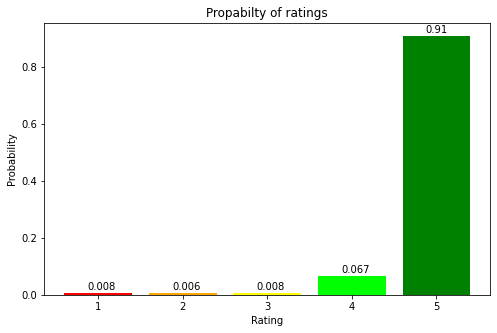

In [ ]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=128,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

In [ ]:
df_test=df_test.dropna()                                                           # Drop NaN valuues, if any
df_test=df_test.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values                            # Print all the unique labels in the dataset
df_test['reviews']=df_test['reviews'].map(preprocess_sentence)  

test_ids=[]
test_masks=[]

test_reviews = df_test['reviews']
for review in test_reviews:
    bert_inp=bert_tokenizer.encode_plus(review, add_special_tokens = True, max_length=50, padding='max_length', return_attention_mask = True)
    test_ids.append(bert_inp['input_ids'])
    test_masks.append(bert_inp['attention_mask'])

test_ids=np.asarray(test_ids)
test_masks=np.array(test_masks)
test_labels = df_test['ratings'].values - 1


In [ ]:
preds = bert_model.predict([test_ids,test_masks])
pred_labels = preds.logits.argmax(axis=1)
f1 = f1_score(test_labels,pred_labels, average='weighted')
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_labels,pred_labels))

from sklearn import metrics
print(metrics.confusion_matrix(test_labels, pred_labels))

F1 score 0.6919871081154714
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1271
           1       0.29      0.20      0.23       630
           2       0.37      0.35      0.36       911
           3       0.39      0.36      0.37      1404
           4       0.84      0.92      0.88      5784

    accuracy                           0.70     10000
   macro avg       0.52      0.49      0.50     10000
weighted avg       0.68      0.70      0.69     10000

[[ 762  196  176   50   87]
 [ 179  123  185   83   60]
 [  62   90  315  312  132]
 [  20   14  115  509  746]
 [  17    8   55  365 5339]]


##Loading Trained model

In [ ]:
trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

model_save_path='/content/drive/MyDrive/DL4NLP/bert_model.h5'
trained_model.load_weights(model_save_path)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Find Predictions

In [ ]:
df_test=df_test.dropna()                                                           # Drop NaN valuues, if any
df_test=df_test.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values                            # Print all the unique labels in the dataset
df_test['reviews']=df_test['reviews'].map(preprocess_sentence)  

test_ids=[]
test_masks=[]

test_reviews = df_test['reviews']
for review in test_reviews:
    bert_inp=bert_tokenizer.encode_plus(review, add_special_tokens = True, max_length=50, padding='max_length', return_attention_mask = True)
    test_ids.append(bert_inp['input_ids'])
    test_masks.append(bert_inp['attention_mask'])

test_ids=np.asarray(test_ids)
test_masks=np.array(test_masks)
test_labels = df_test['ratings'].values - 1

In [ ]:
preds = trained_model.predict([test_ids,test_masks])
pred_labels = preds.logits.argmax(axis=1)
f1 = f1_score(test_labels,pred_labels, average='weighted')
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_labels,pred_labels))

from sklearn import metrics
print(metrics.confusion_matrix(test_labels, pred_labels))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

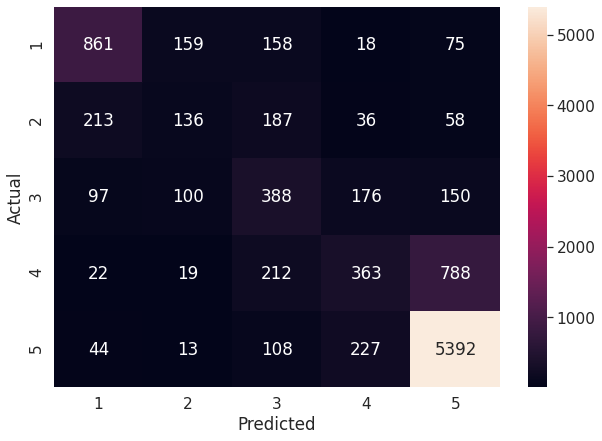

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

data = metrics.confusion_matrix(test_labels, pred_labels)
df_cm = pd.DataFrame(data, columns=np.unique(test_labels+1), index = np.unique(test_labels+1))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size
sn.heatmap(df_cm, annot=True,fmt='d')

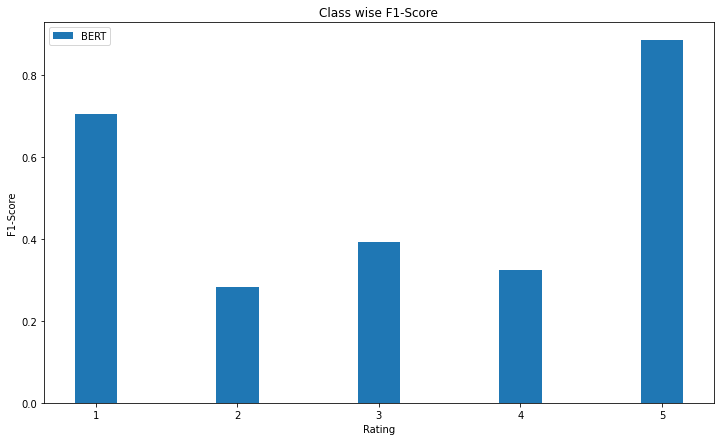

In [ ]:
bert_f1 = f1_score(test_labels,pred_labels, average=None)

ind = np.arange(5) + 1 
width = 0.3

plt.figure(figsize=(12,7))
plt.bar(ind, bert_f1 , width, label='BERT')

plt.xticks(ind, labels = ind)

plt.xlabel('Rating')
plt.ylabel('F1-Score')
plt.title('Class wise F1-Score')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [ ]:
y_test_pred = pred_labels + 1

# convert array into dataframe 
DF = pd.DataFrame(y_test_pred) 
  
# save the dataframe as a csv file 
DF.to_csv("predictions.csv")

#Lime

In [ ]:
def softmax(vector):
	e = np.exp(vector)
	return e / np.sum(e)

def softmax1(x):
  for i in range(len(x)):
    x[i] = softmax(x[i])
  return x 

def get_bert_input(review):
  tokenize_inp = bert_tokenizer.encode_plus(preprocess_sentence(review), add_special_tokens = True, max_length=50, padding='max_length', return_attention_mask = True)
  id = np.array(tokenize_inp['input_ids']).reshape(1,-1)
  mask = np.array(tokenize_inp['attention_mask']).reshape(1,-1)
  bert_input = [id,mask]
  return bert_input

#for single prediction
def get_prediction(review):
  bert_input = get_bert_input(review)
  bert_output = trained_model.predict(bert_input)
  probs = softmax(bert_output.logits)[0]
  return probs

In [ ]:
def predictions(test_reviews):
   ids = []
   masks = []
   for review in test_reviews:
     bert_inp=bert_tokenizer.encode_plus(preprocess_sentence(review), add_special_tokens = True, max_length=50, padding='max_length', return_attention_mask = True)
     ids.append(bert_inp['input_ids'])
     masks.append(bert_inp['attention_mask'])

   ids=np.asarray(ids)
   masks=np.array(masks)

   bert_output = trained_model.predict([ids,masks])
   probs = softmax1(bert_output.logits)
   return probs

In [ ]:
review = "This camera is awesome, I will not recommend this to anybody"
predictions([review])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

array([[0.12311795, 0.04319275, 0.0467938 , 0.04887312, 0.7380224 ]],
      dtype=float32)

In [ ]:
preprocess_sentence(review)

'camera awesome not recommend anybody'

In [ ]:
!pip install lime
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

     |████████████████████████████████| 276kB 6.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=e1415dd35a332f1d53d70244d26f12439661da0ab6777c5ad022ea80499dbe6a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
explainer = LimeTextExplainer(class_names=[1,2,3,4,5])

In [ ]:
exp = explainer.explain_instance(review, predictions, num_features=10, top_labels=1)
exp.show_in_notebook(text=True)

KeyboardInterrupt: ignored

#GUI (Anvil App)

In [ ]:
!pip install anvil-uplink
import anvil.server
import anvil.mpl_util
import anvil.media
anvil.server.connect("KMLP5DPXA3MKYSNZW4IVXBVN-6XOG4E5R4DV7QIIM")

!pip install GrabzIt
from GrabzIt import GrabzItImageOptions
from GrabzIt import GrabzItClient

grabzIt = GrabzItClient.GrabzItClient("ZmMwMTFiZjViZmVlNDY4OGE4YTU0NTkxNzNjOTlmYWE=", "Pz9zPz8/Nj9EPz8LPz8/Pz8/Pz8MbBk/Vj8/TT8/ITw=")

options = GrabzItImageOptions.GrabzItImageOptions()
options.browserHeight = -1
options.width = -1
options.height = -1

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45216 sha256=a10a6d78ec205e7daec3e519353f73315d5108f56bf87d87b894ed5d49a2fa90
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER
     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for GrabzIt: filename=GrabzIt-3.4.5.1-cp37-none-any.whl size=44281 sha256=77c3bcf80d533699d139cdc2edd4b360c7af41709093c6534e8b8a0778dece3e
  Stored in directory: /root/.cache/pip/wheels/09/03/c0/cb12e840d525202eeeabdd50a5228ec9179e1b209329cdb3b9
Successfully built GrabzIt


In [ ]:
@anvil.server.callable
def get_rating(review):
  import matplotlib.pyplot as plt
  %matplotlib inline
  prob = np.round(get_prediction(review),3)
  rating = np.argmax(prob)+1
  plt.rcParams["figure.figsize"]=(8,5)
  plt.title("Propabilty of ratings")
  plt.xlabel('Rating')
  plt.ylabel('Probability')
  plt.bar([1,2,3,4,5],prob, color=['red', 'orange', 'yellow', 'lime', 'green'])
  xlocs, xlabs = plt.xticks()
  xlocs=[i+1 for i in range(0,5)]
  xlabs=[i+1 for i in range(0,5)]
  plt.xticks(xlocs, xlabs)

  for i, v in enumerate(prob):
      # plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
      plt.text(xlocs[i] - 0.125, v + 0.01, str(v))
  plt.xlabel('Rating')
  plt.ylabel('Probability')
  plot = plt.savefig("plot")
  # graph = plt.savefig("plot")
  return prob,rating,anvil.mpl_util.plot_image()


In [ ]:
# @anvil.server.callable
# def lime_result(review):
#   exp = explainer.explain_instance(review, predictions, num_features=10, top_labels=5)
#   fig = exp.as_pyplot_figure(label=exp.available_labels()[0])
#   return anvil.mpl_util.plot_image()

In [ ]:
@anvil.server.callable
def lime_result(review):
  exp = explainer.explain_instance(review, predictions, num_features=10, top_labels = 1)
  exp.save_to_file('/content/cs772_lime.html')
  grabzIt.FileToImage('cs772_lime.html', options)
  grabzIt.SaveTo("lime.png")
  #fig = exp.as_pyplot_figure(label=exp.available_labels()[0])

  return anvil.media.from_file('/content/lime.png')

BlobMedia[None,55634 bytes,name=lime.png]

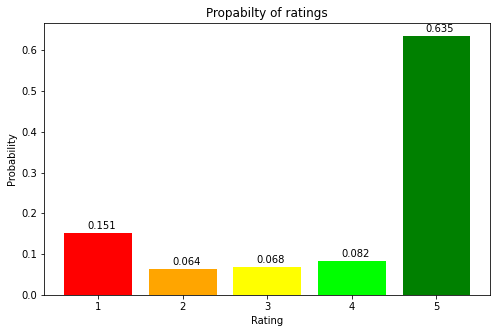

In [ ]:
lime_result(review)

(array([0.489, 0.385, 0.112, 0.01 , 0.004], dtype=float32),
 1,
 BlobMedia[image/png,8187 bytes,name=plot.png])

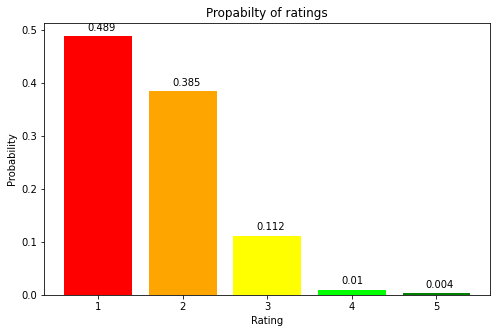

In [ ]:
get_rating("not good product")

array([0.05588271, 0.210139  , 0.5314784 , 0.17545804, 0.02704185],
      dtype=float32)

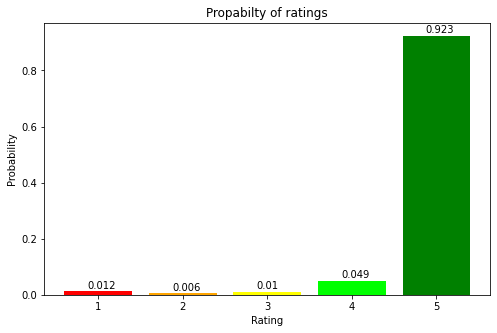

In [ ]:
get_prediction("The product is good, but the box was broken")

In [ ]:
revs = ["What crap.  Would need a lot more power to do what it is saying",
        "Couldn't get it to hold 30 of my 15ml bottles. Liked it being lightweight but wasn't right for me!",
        "i like them but they were bent  and then  i try to get them out the lil bag they were in they broke.",
        "So far, my wife likes this cream and plans to order more.",
        'Been wearing this for several years.. good highlight color over darker or by itself...personally really like.',
        'I really like this item and it works well and it picks up the dog hair']

#Data Analysis

Text(0.5, 1.0, 'Train Data Distribution')

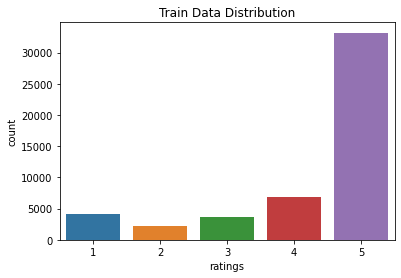

In [ ]:
import seaborn as sns 
sns.countplot(x='ratings', data=data).set_title('Train Data Distribution')

Text(0.5, 1.0, 'Test Data Distribution')

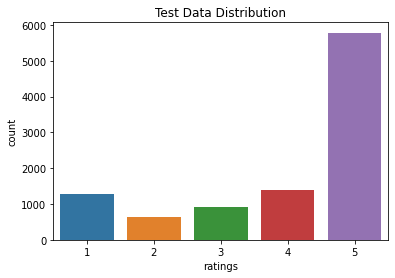

In [ ]:
sns.countplot(x='ratings', data=df_test).set_title('Test Data Distribution')

In [ ]:
reviews = data['reviews']
reviews = reviews.apply(convert_to_lower)
reviews = reviews.apply(remove_punctuations)
reviews = reviews.apply(remove_stopwords)
data['reviews_processed'] = reviews

In [ ]:
df1 = data.loc[data['ratings'] == 1]
df2 = data.loc[data['ratings'] == 2]
df3 = data.loc[data['ratings'] == 3]
df4 = data.loc[data['ratings'] == 4]
df5 = data.loc[data['ratings'] == 5]

In [ ]:
top = 12
r1 = pd.Series(' '.join(df1['reviews_processed']).lower().split()).value_counts()[:top]
r2 = pd.Series(' '.join(df2['reviews_processed']).lower().split()).value_counts()[:top]
r3 = pd.Series(' '.join(df3['reviews_processed']).lower().split()).value_counts()[:top]
r4 = pd.Series(' '.join(df4['reviews_processed']).lower().split()).value_counts()[:top]
r5 = pd.Series(' '.join(df5['reviews_processed']).lower().split()).value_counts()[:top]

In [ ]:
print('Top 12 frequent words in class 1\n',r1.to_frame().T,'\n')
print('Top 12 frequent words in class 2\n',r2.to_frame().T,'\n')
print('Top 12 frequent words in class 3\n',r3.to_frame().T,'\n')
print('Top 12 frequent words in class 4\n',r4.to_frame().T,'\n')
print('Top 12 frequent words in class 5\n',r5.to_frame().T,'\n')

Top 12 frequent words in class 1
     not  product  like  but  work  money  dont  use  hair   no  one  didnt
0  1820      653   487  476   399    397   378  342   312  310  306    297 

Top 12 frequent words in class 2
    not  but  product  like  hair  use  work  good  didnt  one  dont  doesnt
0  925  557      296   260   212  185   178   177    173  173   162     159 

Top 12 frequent words in class 3
     but   not  good  like  product  use  would  great  well   ok  works  really
0  1607  1174   504   458      409  304    284    284   261  257    245     235 

Top 12 frequent words in class 4
     but  good  great  product  not  like  works  well  use  nice  little  love
0  2046  1492   1290     1140  983   972    942   837  817   618     576   554 

Top 12 frequent words in class 5
    great  love  product  good   use  works  well  hair  like   but  skin   not
0   9106  7173     6549  4291  4196   3667  2863  2856  2766  2719  2679  2445 

